## Sensor Data Extraction and Visualization

This notebook processes and visualises sensor data from the OSDB JSON file, which contains information about various users, events, and sensor readings (such as heart rate, oxygen saturation, and raw accelerometer data). The following steps outline the structure of the code and demonstrate how sensor data can be viewed and analysed using this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import pandas as pd
import json

# Load the JSON file
file_path = '../../tests/testData/testDataVisualisation.json'  # Replace with your JSON file path
with open(file_path, 'r') as file:
    raw_json = json.load(file)

In [2]:
# Flatten the JSON and extract relevant fields
flattened_data = []

for attribute in raw_json:
    user_id = attribute.get('userId', None)
    datapoints = attribute.get('datapoints', [])

    for point in datapoints:
        event_id = point.get('eventId', None)
        hr = point.get('hr', [])
        o2Sat = point.get('o2Sat', [])
        rawData = point.get('rawData', [])
        rawData3D = point.get('rawData3D', [])
        # Append every datapoint as a row
        flattened_data.append({
            'eventId': event_id,
            'userId': user_id,
            'hr': hr,
            'o2Sat': o2Sat,
            'rawData': rawData,
            'rawData3D': rawData3D,

        })
        
# Create a DataFrame
df_sensordata = pd.DataFrame(flattened_data)
df_sensordata.to_csv('sensordata.csv', index=False)

# Display the DataFrame
df_sensordata.head()

,eventId,userId,hr,o2Sat,rawData,rawData3D
0,407,39,67,-1,"[1496, 1480, 1500, 1492, 1496, 1484, 1500, 149...",[]
1,407,39,67,-1,"[1492, 1508, 1496, 1476, 1484, 1476, 1496, 150...",[]
2,407,39,68,-1,"[1488, 1496, 1484, 1492, 1492, 1508, 1504, 148...",[]
3,407,39,69,-1,"[1488, 1476, 1480, 1504, 1496, 1508, 1484, 148...",[]
4,407,39,69,-1,"[1504, 1488, 1504, 1492, 1484, 1500, 1496, 149...",[]


In [3]:
# Assuming df_sensordata is your dataframe containing sensor data
event_id = 6897  # Set the eventId 
sensor_df = df_sensordata  # Load the dataframe
filtered_data = sensor_df[sensor_df['eventId'] == event_id]  # Filter dataframe by the eventId

# Ensure there is data for the event
if filtered_data.empty:
    raise ValueError(f"No data found for event ID {event_id}")

# Extract rawData and rawData3D
raw_data = np.hstack(filtered_data['rawData'].dropna().values) if 'rawData' in filtered_data else np.array([])
raw_data3d = (
    np.vstack(filtered_data['rawData3D'].dropna().values)
    if 'rawData3D' in filtered_data and not filtered_data['rawData3D'].dropna().empty
    else np.array([])
)

# Extract HR and O2Sat data
hr = filtered_data['hr'].dropna().tolist()
o2_sat = filtered_data['o2Sat'].dropna().tolist()

# Define sample rates
raw_sample_rate = 125  # 125 samples per second for rawData and rawData3D
hr_spo2_sample_interval = 5  # HR and SpO₂ data sampled every 5 seconds

# Total number of rows for the event (each row is 5 seconds of data)
num_rows = len(filtered_data)

# Calculate the total duration for the event
total_duration = num_rows * 5  # Each row represents 5 seconds

# Generate the x-axis points for each dataset
time_raw_data = np.linspace(0, total_duration, len(raw_data))
time_raw_data3d = np.linspace(0, total_duration, len(raw_data3d))
time_hr_spo2 = np.arange(0, len(hr) * hr_spo2_sample_interval, hr_spo2_sample_interval)


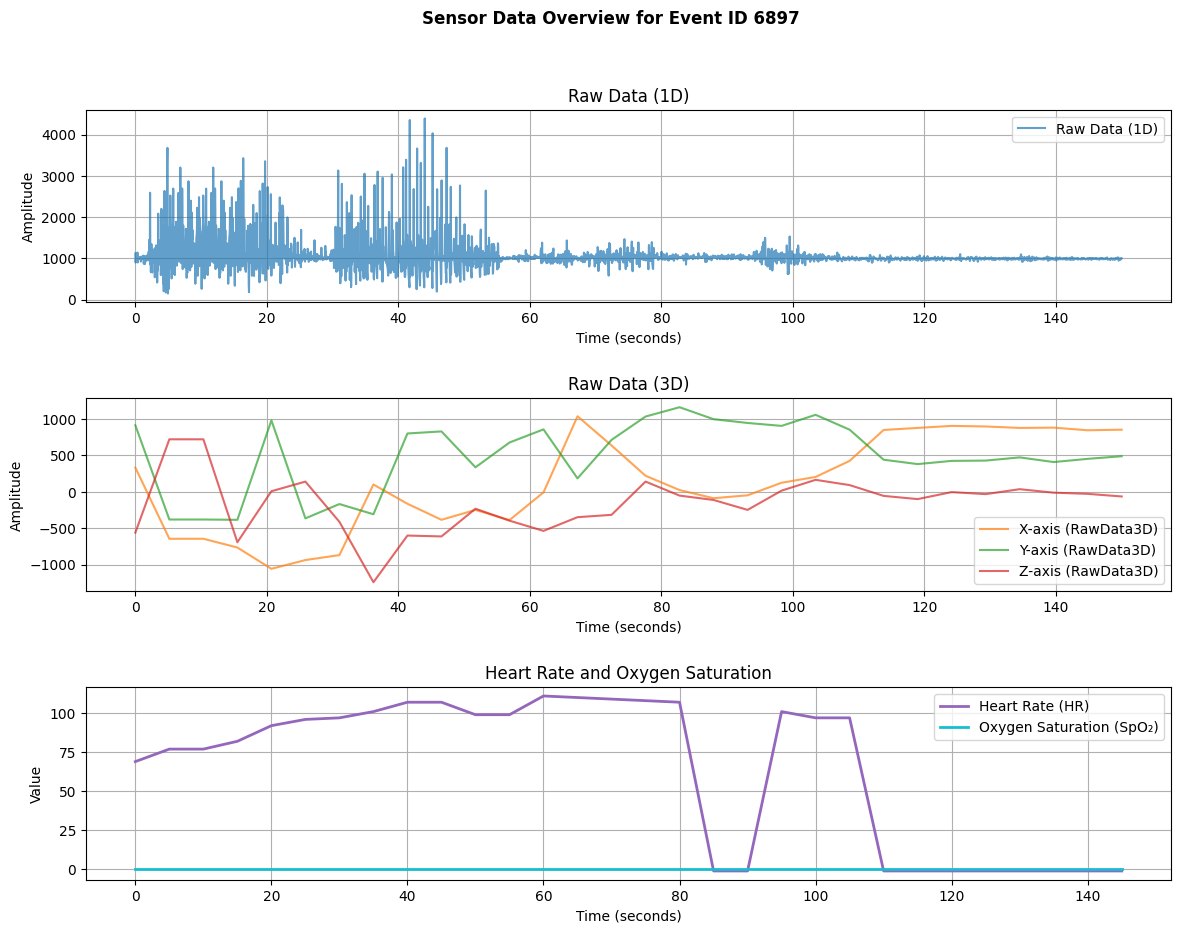

In [4]:

# Create the plot with dynamic subplots
if raw_data3d.size > 0:  # If rawData3D is available, create 3 subplots
    subplot_ratios = [1, 1, 1]  # 33% each
    nrows = 3
else:  # Only rawData and HR/SpO₂
    subplot_ratios = [1, 1]  # 50% each
    nrows = 2

fig, axs = plt.subplots(
    nrows,
    1,
    figsize=(14, 10),
    gridspec_kw={'height_ratios': subplot_ratios, 'hspace': 0.5}  # Add space between plots
)
fig.suptitle(f"Sensor Data Overview for Event ID {event_id}", fontsize=12, fontweight='bold')

# Plot rawData on the first subplot
axs[0].plot(time_raw_data, raw_data, label="Raw Data (1D)", color='tab:blue', alpha=0.7)
axs[0].set_title("Raw Data (1D)")
axs[0].set_xlabel("Time (seconds)")
axs[0].set_ylabel("Amplitude")
axs[0].legend()
axs[0].grid()

# Plot rawData3D on the second subplot if available
if raw_data3d.size > 0:
    axs[1].plot(time_raw_data3d, raw_data3d[:, 0], label="X-axis (RawData3D)", color='tab:orange', alpha=0.7)
    axs[1].plot(time_raw_data3d, raw_data3d[:, 1], label="Y-axis (RawData3D)", color='tab:green', alpha=0.7)
    axs[1].plot(time_raw_data3d, raw_data3d[:, 2], label="Z-axis (RawData3D)", color='tab:red', alpha=0.7)
    axs[1].set_title("Raw Data (3D)")
    axs[1].set_xlabel("Time (seconds)")
    axs[1].set_ylabel("Amplitude")
    axs[1].legend()
    axs[1].grid()
else:
    print("rawData3D is empty or not available.")

# Plot HR and SpO₂ on the last subplot
hr_spo2_ax_index = 2 if raw_data3d.size > 0 else 1
if hr and o2_sat:
    axs[hr_spo2_ax_index].plot(time_hr_spo2, hr, label="Heart Rate (HR)", color='tab:purple', linewidth=2)
    axs[hr_spo2_ax_index].plot(time_hr_spo2, o2_sat, label="Oxygen Saturation (SpO₂)", color='tab:cyan', linewidth=2)
axs[hr_spo2_ax_index].set_title("Heart Rate and Oxygen Saturation")
axs[hr_spo2_ax_index].set_xlabel("Time (seconds)")
axs[hr_spo2_ax_index].set_ylabel("Value")
axs[hr_spo2_ax_index].legend()
axs[hr_spo2_ax_index].grid()

# Adjust layout and show the plot
plt.show()


## 1. Flattening the JSON Structure

The JSON data is nested and contains multiple layers. To make it easier to work with, we flatten the nested structure into a more manageable format (a 2D table). Each entry in the JSON is processed to extract relevant fields.

### Process:
- We iterate over each entry in the raw JSON data and extract the following fields:
  - `userId`: The ID of the user.
  - `datapoints`: A list of sensor data entries associated with that user.

Each data point within `datapoints` contains:
- `eventId`: The ID of the event.
- `hr`: Heart rate data
- `o2Sat`: Oxygen saturation data 
- `rawData`: 1D accelerometer data (list).
- `rawData3D`: 3D accelerometer data (list).

The data is flattened into a simple table where each row represents one 5 second timestep of sensor data.

## 2. Extracting and Processing Sensor Data

The raw sensor data (heart rate (HR), oxygen saturation (O2Sat), and accelerometer data (both 1D and 3D)) is filtered and processed from the dataframe. The following steps outline the process of filtering and extracting data for a specific event, followed by preparing the time intervals for visualization.

### Process:
1. **Filtering the Data by Event ID:**
   - The code filters the sensor data to isolate the readings corresponding to a specific event, identified by the `event_id`.
   - The dataframe is filtered using the `eventId` column to extract relevant entries for the specified event.

2. **Extracting Raw Data:**
   - The `rawData` (1D accelerometer data) and `rawData3D` (3D accelerometer data) are extracted for the given event.
   - Any missing values are dropped before the data is processed, ensuring clean and complete data for analysis.

3. **Extracting HR and O2Sat Data:**
   - The heart rate (`hr`) and oxygen saturation (`o2Sat`) readings are also extracted for the event, with missing values dropped to maintain integrity.

4. **Defining Sample Rates:**
   - The sample rate for the accelerometer data is set at **125 samples per second**.
   - The HR and O2Sat data are sampled every **5 seconds**, represented by the `hr_spo2_sample_interval`.

5. **Calculating Total Duration and Time Intervals:**
   - The total duration of the event is calculated based on the number of rows in the dataset, with each row representing **5 seconds of data**.
   - The time intervals for each sensor dataset are generated:
     - For the accelerometer data (`rawData` and `rawData3D`), the time axis is created based on the total duration.
     - For the HR and O2Sat data, the time axis is created with intervals of 5 seconds.

---


# 👤 Author  
Developed by **Jamie Pordoy**.